# Modelos ML regresión (precio ticket)

## Importar librerías

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly_express as px
import matplotlib.pyplot as plt

## Data 'tickets'

In [2]:
link_data = "https://docs.google.com/spreadsheets/d/1QvsVM0K2YZWGuFNoKJzaZrRFsvCtmYbMCTvf3twFCgY/export?format=csv"
tickets = pd.read_csv(link_data)
print(tickets.head())

                      event_url                                 title  \
0  https://feverup.com/m/100120  Top Stand-Up Comedy in Covent Garden   
1  https://feverup.com/m/100120  Top Stand-Up Comedy in Covent Garden   
2  https://feverup.com/m/100120  Top Stand-Up Comedy in Covent Garden   
3  https://feverup.com/m/100120  Top Stand-Up Comedy in Covent Garden   
4  https://feverup.com/m/100120  Top Stand-Up Comedy in Covent Garden   

        datetime_local    city    state country postal_code  ticket_id  \
0  2023-10-27 20:30:00  London  England      GB    WC2H 9LA   36853293   
1  2023-10-27 20:30:00  London  England      GB    WC2H 9LA   36853261   
2  2023-10-20 20:30:00  London  England      GB    WC2H 9LA   36853292   
3  2023-10-20 20:30:00  London  England      GB    WC2H 9LA   36853259   
4  2023-10-21 20:30:00  London  England      GB    WC2H 9LA   36853324   

   ticket_price  total_price  quantity event_category  
0          16.0         16.0        50        THEATER  
1   

In [3]:
tickets.columns

Index(['event_url', 'title', 'datetime_local', 'city', 'state', 'country',
       'postal_code', 'ticket_id', 'ticket_price', 'total_price', 'quantity',
       'event_category'],
      dtype='object')

In [4]:
tickets.shape

(2655, 12)

In [5]:
tickets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2655 entries, 0 to 2654
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   event_url       2655 non-null   object 
 1   title           2655 non-null   object 
 2   datetime_local  2655 non-null   object 
 3   city            2655 non-null   object 
 4   state           2655 non-null   object 
 5   country         2655 non-null   object 
 6   postal_code     2655 non-null   object 
 7   ticket_id       2655 non-null   int64  
 8   ticket_price    2655 non-null   float64
 9   total_price     2655 non-null   float64
 10  quantity        2655 non-null   int64  
 11  event_category  2655 non-null   object 
dtypes: float64(2), int64(2), object(8)
memory usage: 249.0+ KB


Variables para el estudio: 'ticket_price', 'total_price', 'quantity'. La variable objetivo será 'ticket_price'

## 1. Arreglar valores nulos y outliers

In [6]:
tickets.isnull().sum()

event_url         0
title             0
datetime_local    0
city              0
state             0
country           0
postal_code       0
ticket_id         0
ticket_price      0
total_price       0
quantity          0
event_category    0
dtype: int64

In [7]:
# DISTRIBUCIÓN COLUMNA 'total_price' (visualizar outliers)
df_tips = tickets.sort_values(by='total_price')              # Ordenar precios en 'total_price'
fig = px.box(df_tips, x='total_price')                       # Crear el gráfico de caja con los datos ordenados
fig.show()

In [8]:
# DISTRIBUCIÓN COLUMNA 'ticket_price' (visualizar outliers)
df_tips = tickets.sort_values(by='ticket_price')              # Ordenar precios en 'ticket_price'
fig = px.box(df_tips, x='ticket_price')                       # Crear el gráfico de caja con los datos ordenados
fig.show()

In [9]:
tickets['ticket_id'] = tickets['ticket_id'].astype(str)     # columna 'ticket_id' a string
tickets.describe().T

,count,mean,std,min,25%,50%,75%,max
ticket_price,2655.0,94.415224,89.928766,5.0,16.0,40.00,180.0,270.0
total_price,2655.0,94.449808,89.910965,5.0,16.0,43.55,180.0,270.0
quantity,2655.0,10.126930,12.580086,1.0,1.0,12.00,12.0,100.0


In [10]:
correlation = tickets[['ticket_price', 'total_price', 'quantity']].corr(method='pearson')
print(correlation)

# Los precios de los tickets individuales tienden a aumentar cuando el precio total de la transacción aumenta (0.99)

              ticket_price  total_price  quantity
ticket_price      1.000000     0.999991 -0.531853
total_price       0.999991     1.000000 -0.531702
quantity         -0.531853    -0.531702  1.000000


## 2. Dividir en grupos 'train' y 'test'

In [11]:
from sklearn.model_selection import train_test_split

# Selección características (X) y variable objetivo (y)
X = pd.DataFrame(df_tips[['total_price', 'quantity']].values, columns=['total_bill', 'size'])
y = pd.Series(df_tips['ticket_price'].values)

# División de los datos en conjunto de entrenamiento y conjunto de prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)    # El 25% de los datos se utilizarán para el conjunto de prueba y el 75% para el conjunto de entrenamiento

## 3. Normalizar variables de 'train' y 'test'

In [12]:
from sklearn.preprocessing import StandardScaler

# Inicializar StandardScaler
scaler = StandardScaler()

# Ajustar y transformar los datos de entrenamiento
X_train_normalized = scaler.fit_transform(X_train)

# Utilizar los mismos parámetros de escala para transformar los datos de prueba
X_test_normalized = scaler.transform(X_test)

# En 'X_test_normalized' se utiliza el método transform() en lugar del método fit_transform(). 
# Esto se debe a que ya hemos ajustado el scaler a los datos de entrenamiento, por lo que solo
# necesitamos aplicar la misma transformación de normalización a los datos de prueba.

## 4. Entrenar modelos de regresión 

#### *  Elastic Net  *

In [13]:
# BÚSQUEDA ALEATORIA DE HIPERPARÁMETROS, A GRAN ESCALA (randomized)
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import RepeatedKFold                           # RepeatedKFold -> evalúa el rendimiento del modelo (estrategia de validación cruzada)
from sklearn.model_selection import RandomizedSearchCV                      # RandomizedSearchCV -> realiza la búsqueda aleatoria de hiperparámetros
from sklearn.metrics import mean_squared_error as mse                       # Función para calcular el error cuadrático medio


elastic_net_model = ElasticNet()                                            # Definición del modelo (ElasticNet)                                                                                                           
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)                 # Definición de estrategia de validación cruzada (5 divisiones de los datos en cada repetición, y el proceso se repetirá 3 veces)                                                                              # Definir estrategia de validación cruzada
space = {'alpha': [0.01, 0.1, 1.0], 'l1_ratio': [0.1, 0.5, 0.9]}            # Definición del espacio de búsqueda de hiperparámetros                                                                       
search = RandomizedSearchCV(elastic_net_model, space, n_iter=50, scoring='neg_mean_squared_error', n_jobs=-1, cv=cv, random_state=1)        # Iniciar búsqueda aleatoria de hiperparámetros

# Entrenar búsqueda
resultRS = search.fit(X_train_normalized, y_train)

# Recoger resultados
print('Best Score: %s' % resultRS.best_score_)
print('Best Hyperparameters: %s' % resultRS.best_params_)

c:\Users\Marta\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning:

The total space of parameters 9 is smaller than n_iter=50. Running 9 iterations. For exhaustive searches, use GridSearchCV.



Best Score: -0.18408157988518592
Best Hyperparameters: {'l1_ratio': 0.9, 'alpha': 0.01}


In [14]:
# BÚSQUEDA ALEATORIA DE HIPERPARÁMETROS, A MENOR ESCALA
from sklearn.model_selection import GridSearchCV

# Definir espacio de búsqueda de hiperparámetros a partir de los resultados de la búsqueda aleatoria
space = {'alpha': np.arange(resultRS.best_params_['alpha'] * 0.5, resultRS.best_params_['alpha'] * 1.5, 0.01),
         'l1_ratio': np.arange(max(0.0, resultRS.best_params_['l1_ratio'] - 0.5), min(1.0, resultRS.best_params_['l1_ratio'] + 0.5), 0.01)}

# Iniciar búsqueda en cuadrícula de hiperparámetros
search = GridSearchCV(elastic_net_model, space, scoring='neg_mean_squared_error', n_jobs=-1, cv=cv)

# Entrenar búsqueda
resultGS = search.fit(X_train_normalized, y_train)

# Recoger resultados
print('Best Score: %s' % resultGS.best_score_)
print('Best Hyperparameters: %s' % resultGS.best_params_)

Best Score: -0.17212339109367336
Best Hyperparameters: {'alpha': 0.005, 'l1_ratio': 0.9900000000000005}


In [15]:
# APLICAR MODELO
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error as mse

# Inicializar modelo y parámetros
alpha = 0.005
l1_ratio = 0.9900000000000005

# Instanciar el modelo
elastic_net_model = ElasticNet(alpha = alpha, l1_ratio = l1_ratio, max_iter = 100, random_state = 0)

# Entrenar modelo y elaborar predicciones
elastic_net_model.fit(X_train_normalized, y_train)
y_pred = elastic_net_model.predict(X_test_normalized)
mse_ElasticNet = mse(y_test, y_pred) 
mse_ElasticNet

0.08125031563526638

In [16]:
print(mse_ElasticNet**.5)
# Muestra la raíz cuadrada del error cuadrático medio, lo que nos da una idea más intuitiva de la 
# magnitud # de los errores del modelo en términos de la variable objetivo. Esto facilita la 
# interpretación y comparación # del rendimiento de diferentes modelos.

0.2850444099351299


#### * Stochastic Gradient Descent *

In [17]:
# BÚSQUEDA ALEATORIA DE HIPERPARÁMETROS, A GRAN ESCALA
#Librerías
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import RepeatedKFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error as mse

SGD = SGDRegressor()                                                                                                                        # Definir modelo ElasticNet
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)                                                                                 # Definir estrategia de validación cruzada
space = {'alpha': [0.01, 0.1, 1.0], 'l1_ratio': [0.1, 0.5, 0.9]}                                                                            # Definir espacio de búsqueda de hiperparámetros
search = RandomizedSearchCV(elastic_net_model, space, n_iter=50, scoring='neg_mean_squared_error', n_jobs=-1, cv=cv, random_state=1)        # Iniciar búsqueda aleatoria de hiperparámetros

# Entrenar búsqueda
resultRS = search.fit(X_train_normalized, y_train)

# Recoger resultados
print('Best Score: %s' % resultRS.best_score_)
print('Best Hyperparameters: %s' % resultRS.best_params_)


c:\Users\Marta\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning:

The total space of parameters 9 is smaller than n_iter=50. Running 9 iterations. For exhaustive searches, use GridSearchCV.



Best Score: -0.18408157988518592
Best Hyperparameters: {'l1_ratio': 0.9, 'alpha': 0.01}


In [18]:
# BÚSQUEDA ALEATORIA DE HIPERPARÁMETROS, A MENOR ESCALA
from sklearn.model_selection import GridSearchCV

# Definir espacio de búsqueda de hiperparámetros a partir de los resultados de la búsqueda aleatoria
space = {'alpha': np.arange(resultRS.best_params_['alpha'] * 0.5, resultRS.best_params_['alpha'] * 1.5, 0.01),
         'l1_ratio': np.arange(max(0.0, resultRS.best_params_['l1_ratio'] * 0.5), min(1.0, resultRS.best_params_['l1_ratio'] * 1.5), 0.01)}

# Iniciar búsqueda en cuadrícula de hiperparámetros
search = GridSearchCV(SGD, space, scoring='neg_mean_squared_error', n_jobs=-1, cv=cv)

# Entrenar búsqueda
resultGS = search.fit(X_train_normalized, y_train)

# Recoger resultados
print('Best Score: %s' % resultGS.best_score_)
print('Best Hyperparameters: %s' % resultGS.best_params_)

Best Score: -0.4473278103370947
Best Hyperparameters: {'alpha': 0.005, 'l1_ratio': 0.5700000000000001}


In [19]:
# APLICAR MODELO
from sklearn.linear_model import SGDRegressor

# Inicializamos modelo y parámetros
penalty = 'elasticnet'                                          # Elegimos entre penalización 'l2', 'l1' o 'elasticnet'
alpha = 0.005                                                   # Parámetro que mide el peso que tienen los regularizadores frente a la función original
l1_ratio = 0.8500000000000003                                   # Parámetro que mide el tradeoff entre el peso l1 y el l2

# Instanciamos el modelo
SGD_model = SGDRegressor(penalty = penalty, alpha = alpha, l1_ratio = l1_ratio, max_iter = 100, random_state = 0)

# Entrenamos modelo y elaboramos predicciones
SGD_model.fit(X_train, y_train)
mse_SGDRegressor = mse(y_test,SGD_model.predict(X_test))
print(mse_SGDRegressor**.5) 
print(mse_SGDRegressor)

9476138824495.055
8.97972070211025e+25


#### * Support vector regression *

In [20]:
#Librerías
from sklearn import svm

#Inicializamos modelo y parámetros
C = 1                                           # Parámetro regularizador
kernel = 'rbf'                                  # Núcleo transformador

#Instanciamos el modelo
model = svm.SVR(C = C, kernel = kernel)

#Entrenamos modelo y elaboramos predicciones
model.fit(X_train_normalized, y_train)
mse_SVR = mse(y_test,model.predict(X_test))
print(mse_SVR**.5) 
print(mse_SVR) 

89.80848329054686
8065.563670948434


c:\Users\Marta\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:486: UserWarning:

X has feature names, but SVR was fitted without feature names



#### * Random Forest *

In [21]:
#Librerías
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as mse

#Inicializamos modelo y parámetros
n_estimators = 200                                      # Estimadores del modelo
criterion = 'squared_error'                             # Forma de calcular el error
max_depth = None                                        # Límite de profundidad de los árboles
min_samples_split = 2                                   # Criterio de parada de profundidad
verbose = 1                                             # Información devuelta por el método

#Instanciamos el modelo
model = RandomForestRegressor(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split, verbose=verbose)

#Entrenamos modelo y elaboramos predicciones
model.fit(X_train_normalized, y_train)
mse_RF = mse(y_test, model.predict(X_test_normalized))
print(mse_RF**.5)
print(mse_RF)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s


0.8892195018963042
0.7907113225527114


#### * Boosting: *Gradient Descent* *

In [23]:
# Librerías
import xgboost as xgb
from sklearn.metrics import mean_squared_error as mse

# Inicializamos modelo y parámetros
params = {"booster":"gbtree", "max_depth": 2, "eta": 0.3, "objective": "reg:squarederror", "nthread":2}
num_boost_round = 10

# Convertimos los datos a formato DMatrix
train_data = xgb.DMatrix(X_train_normalized, label=y_train)    # Este modelo necesita generar su propio dataframe, que en este caso es un DMatrix
test_data = xgb.DMatrix(X_test_normalized, label=y_test)

# Instanciamos el modelo, entrenamos y elaboramos predicciones
boosting_model = xgb.train(params = params, dtrain = train_data, num_boost_round=num_boost_round)
mse_XGB = mse(y_test, boosting_model.predict(test_data))
print(mse_XGB)

11.095197455151068


## 5. Comparativa resultados

([0, 1, 2, 3, 4],
 [Text(0, 0, 'ElasticNet'),
  Text(1, 0, 'SGDRegressor'),
  Text(2, 0, 'SupportVectorRegression'),
  Text(3, 0, 'Random Forest'),
  Text(4, 0, 'Boosting')])

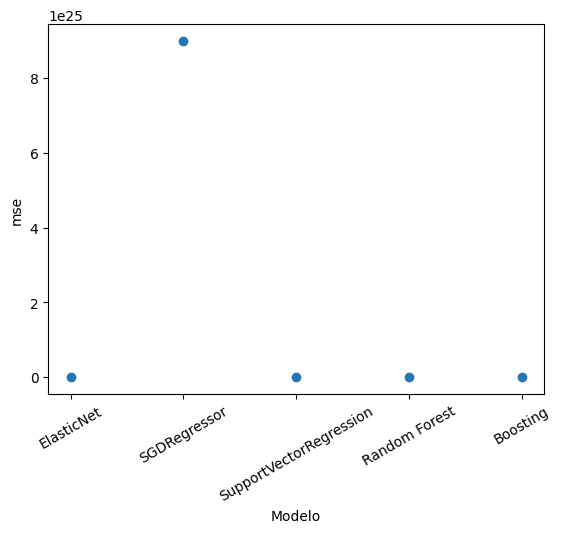

In [24]:
mse = [mse_ElasticNet, mse_SGDRegressor, mse_SVR, mse_RF, mse_XGB]

plt.scatter(['ElasticNet', 'SGDRegressor', 'SupportVectorRegression', 'Random Forest', 'Boosting'], mse)
plt.ylabel('mse')
plt.xlabel('Modelo')
plt.xticks(rotation=30)

([0, 1], [Text(0, 0, 'ElasticNet'), Text(1, 0, 'Random Forest')])

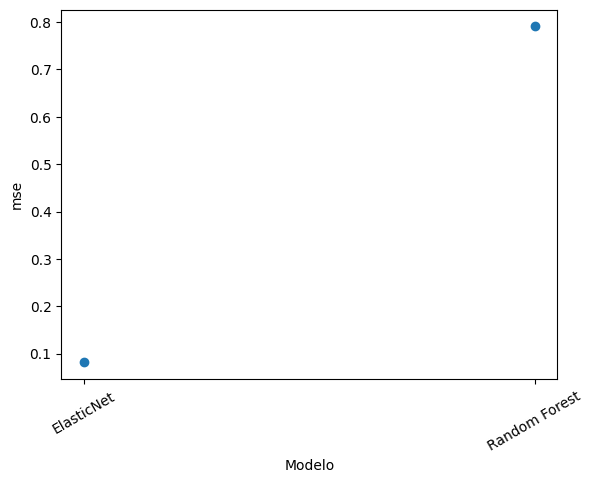

In [25]:
# SELECCIÓN CON LOS 2 MODELOS CON ERROR MÁS BAJO
mse = [mse_ElasticNet, mse_RF]

plt.scatter(['ElasticNet', 'Random Forest'], mse)
plt.ylabel('mse')
plt.xlabel('Modelo')
plt.xticks(rotation=30)

## CONCLUSIÓN: 
El modelo ‘ElasticNet’ es el que tiene el mse más bajo y que por tanto, es el que mejor se ajusta a los datos tras el entrenamiento del modelo. Pero decido realizar más experimentos, ya que considero que se puede optimizar y conseguir modelos mejores con selecciones y formato distinto de las variables.